In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

data_path = '../data/updated_cleaned_patient_data.csv'
data = pd.read_csv(data_path)

feature_cols = [
    'FBS', 'BMI', 'Diabetes', 'age', 'hypertension',
    'vegetarian (1= yes, 0=no)', 'Exercise (min/week)',
    'Cholesterol', 'Living_Area_Code', 'Marriage_Status_Code'
]

data['text'] = data[feature_cols].astype(str).agg(' '.join, axis=1)

X = data['text']
y = data['stroke']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,3),
    min_df=3,
    max_df=0.8
)

In [63]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = MultinomialNB(alpha=5.0,fit_prior=False)

model.fit(X_train_tfidf, y_train)

train_pred = model.predict(X_train_tfidf)
test_pred = model.predict(X_test_tfidf)

print("Train Accuracy :", accuracy_score(y_train, train_pred))
print("Test Accuracy :", accuracy_score(y_test, test_pred))
print(classification_report(y_test, test_pred))

Train Accuracy : 0.81625
Test Accuracy : 0.805
              precision    recall  f1-score   support

           0       0.83      0.95      0.88       156
           1       0.62      0.30      0.40        44

    accuracy                           0.81       200
   macro avg       0.72      0.62      0.64       200
weighted avg       0.78      0.81      0.78       200



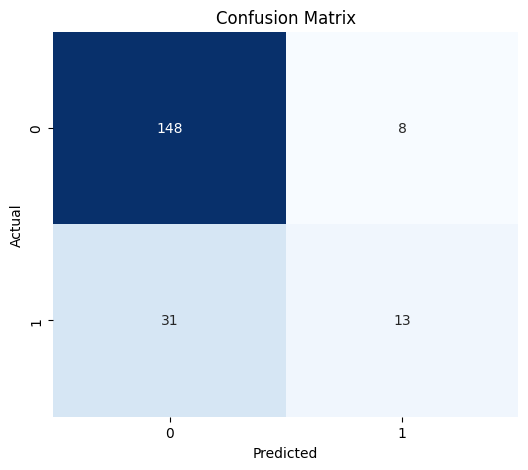

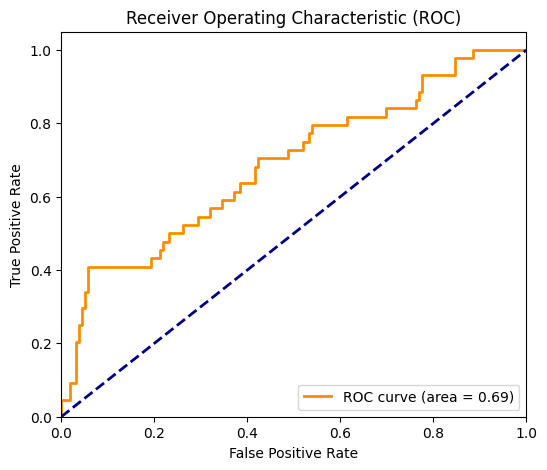

C:\Users\COMASUS\AppData\Local\Temp\ipykernel_24464\890639789.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_probs, y=top_features, palette='viridis')


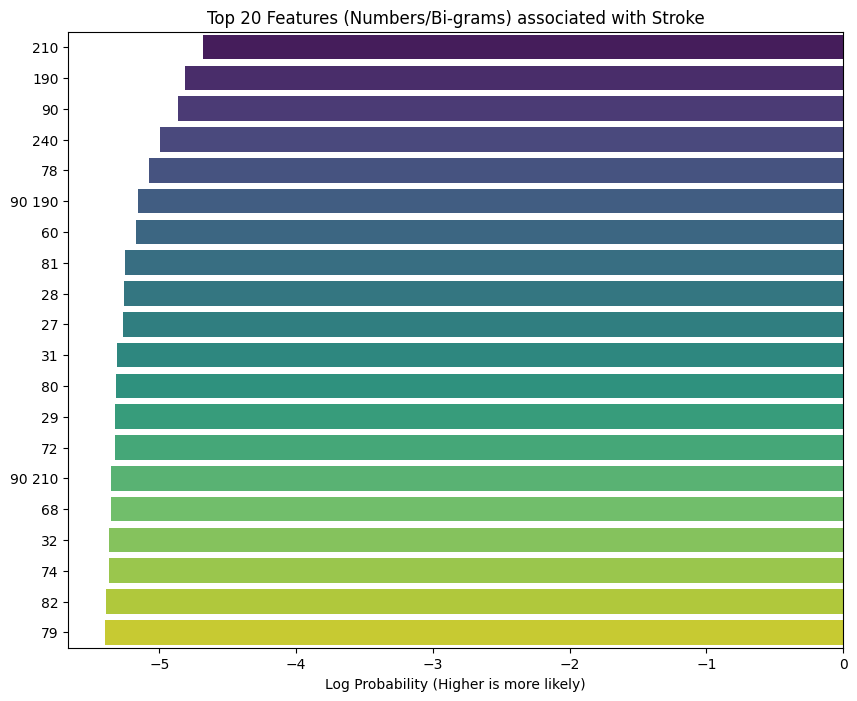

In [64]:
# --- ส่วนที่เขียนต่อ (Visualization) ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Confusion Matrix (ทายถูก/ผิด)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 2. ROC Curve (ดูกราฟความแม่นยำ)
# ต้องใช้ predict_proba เพื่อเอาค่าความน่าจะเป็น
y_prob = model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# 3. Top Features (ดูว่า "คำ" หรือ "ตัวเลข" ไหนที่โมเดลให้ความสำคัญ)
# ดึงชื่อ Feature (คำศัพท์) ออกมาจาก Vectorizer
feature_names = vectorizer.get_feature_names_out()

# ดึงค่า Log Probability ของ Class 1 (Stroke)
log_probs = model.feature_log_prob_[1]

# เรียงลำดับจากมากไปน้อย แล้วตัดมาแค่ 20 อันดับแรก
top_n = 20
sorted_ids = np.argsort(log_probs)[::-1][:top_n]
top_features = feature_names[sorted_ids]
top_probs = log_probs[sorted_ids]

plt.figure(figsize=(10, 8))
sns.barplot(x=top_probs, y=top_features, palette='viridis')
plt.title(f'Top {top_n} Features (Numbers/Bi-grams) associated with Stroke')
plt.xlabel('Log Probability (Higher is more likely)')
plt.show()

In [65]:
print(y.value_counts(normalize=True) * 100)

stroke
0    75.1
1    24.9
Name: proportion, dtype: float64
